In [1]:
# Load Basic Libraries
%pylab inline

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display, Math, Latex
from sklearn.decomposition import SparsePCA, PCA
from sklearn.preprocessing import scale, normalize
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score

In [ ]:
# Load Our Modules

%load_ext autoreload
%autoreload 2

# Run this notebook outside of main module tree
import os
import sys
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)

# Import our libs
from surveys.personality import *
from utils.factors import *
from factor_rotation._analytic_rotation import target_rotation
from factor_rotation._gpa_rotation import orthomax_objective, GPA, rotateA as rotate
from factor_rotation._wrappers import rotate_factors

In [94]:
# Helper Functions

def get_exlained_variance(df, L, PCA= True, p = 5):
    # sklearn mangles the PCA loadings, so we treat it differently
    if PCA:
        F = df.dot(normalize(L).T)
        v =  np.var(F, axis=0)/np.var(df).sum() * 100 
    else:
        v = np.sum(L ** 2, axis=1)/np.var(df).sum() * 100
    print 'Summed variance of first %s components: %s' % (p,v[0:p].sum())
    return v

def get_spearman_corr(A, B):
    _, factors = A.shape
    return np.array([scipy.stats.spearmanr(A[:,i], B[:,i]).correlation 
                     for i in range(factors)])

def make_score_df(scores, columns):
    """ Takes 5-row array or list and makes into printable DF"""
    df = pd.DataFrame(scores, columns = columns)
    df.index = bf_names
    return df
    

In [95]:
X = prep_X(read_surveys("../data"))
bf_survey = X.iloc[:, 0:65]
bf_survey_scaled = pd.DataFrame(scale(bf_survey))
others = X.iloc[:, 65:]
others_scaled = pd.DataFrame(scale(others))
ids = read_surveys("../data").user_id

# Get the big five components, sparse positie loadings for the questions that
# refer to personality traits. 
bigfive_key = pd.read_csv("../data/educatalyst/Auxil/q1_key_bigfive.csv")
bf_comps = get_big_five_comps(bigfive_key)
bf_names = bigfive_key.bigfive_lbl_eng.unique()
# Projec the survey data onto those big five personality components
bigfive = big_five_projection(bigfive_key, bf_survey)
bigfive_scaled = big_five_projection(bigfive_key, bf_survey_scaled)

# Validity of Ground Truth

In [101]:
# Cronbach's Alpha for each trait.

comps = np.ceil(bf_comps)
inds = np.var(bf_survey).T.dot(comps)
tots = np.var((bf_survey).dot(comps)).as_matrix()
cronbach = (1 - (inds / tots)) / (13.0/12)
make_score_df(cronbach, ["Cronbach's Alpha"])

,Cronbach's Alpha
Energy / Extraversion,0.734160
Agreeableness,0.732515
Conscientiousness,0.733814
Emotional Instability,0.683532
Intellect / Openness,0.746526


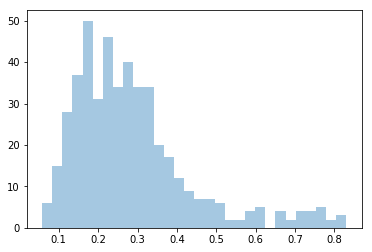

In [100]:
# Variance of individual users answers within each trait.

np.var(bf_survey * comps[:,0], axis = 1)
scaled = bf_survey / np.sqrt(np.var(bf_survey))
d = np.array([np.var(scaled * comps[:,i], axis = 1) for i in range(5)]).T
p = sns.distplot(d.flatten(), bins = 30, kde = False)

# Regression

In [103]:
# Run Elastic Net regression and report Pearson Correlations!

enet = MultiElasticNet(alpha = 0.4, l1_ratio = .5) # Params chosen via 5-fold CV
fitted = enet.fit(others, bigfive.as_matrix())
L = np.array(enet.coef_).T
make_score_df(max_corr(others_scaled.dot(L), bigfive), ["Pearson Correlation"]) 

,Pearson Correlation
Energy / Extraversion,0.800271
Agreeableness,0.803592
Conscientiousness,0.840472
Emotional Instability,0.599498
Intellect / Openness,0.825383


In [104]:
import scipy

spearmans = get_spearman_corr(others_scaled.dot(L).as_matrix(), bigfive.as_matrix())
make_score_df(spearmans, ["Spearmans Correlation"])

,Spearmans Correlation
Energy / Extraversion,0.675531
Agreeableness,0.693583
Conscientiousness,0.805793
Emotional Instability,0.541523
Intellect / Openness,0.801067
